<a href="https://colab.research.google.com/github/neenumohan/LSTM/blob/main/LSTM_at_DCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Timeseries Forecasting for Weather Prediction**
## Hands-on session for An Insight into LSTMs
### for Department of Computational Biology and Bioinformatics, University of Kerala

Session Handled by Vishnu Nair


---

 *⚠ Please turn on GPU Processing*

# Step 1: Initializing

In [ ]:
!nvidia-smi

Mon Jun  7 05:18:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)

# Step 2: Import the dataset

In [ ]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


Understanding the dataset



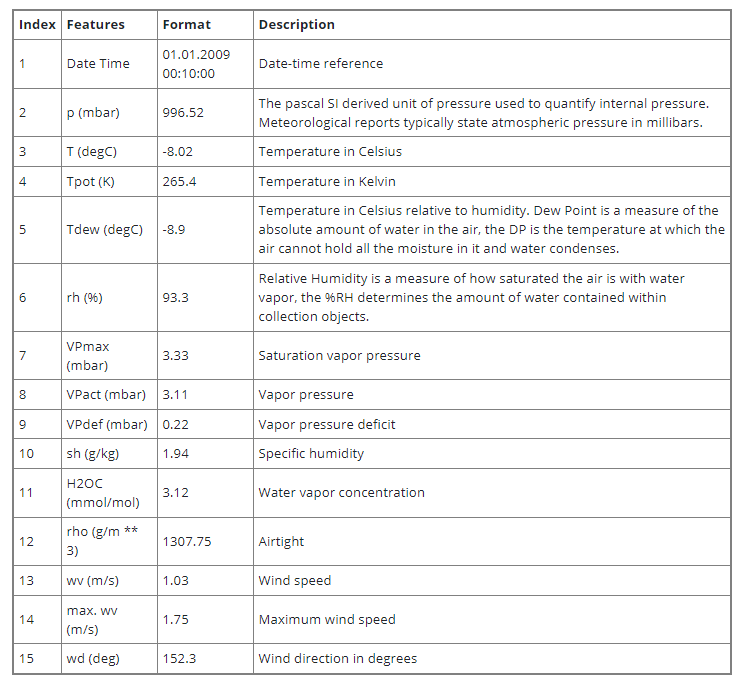

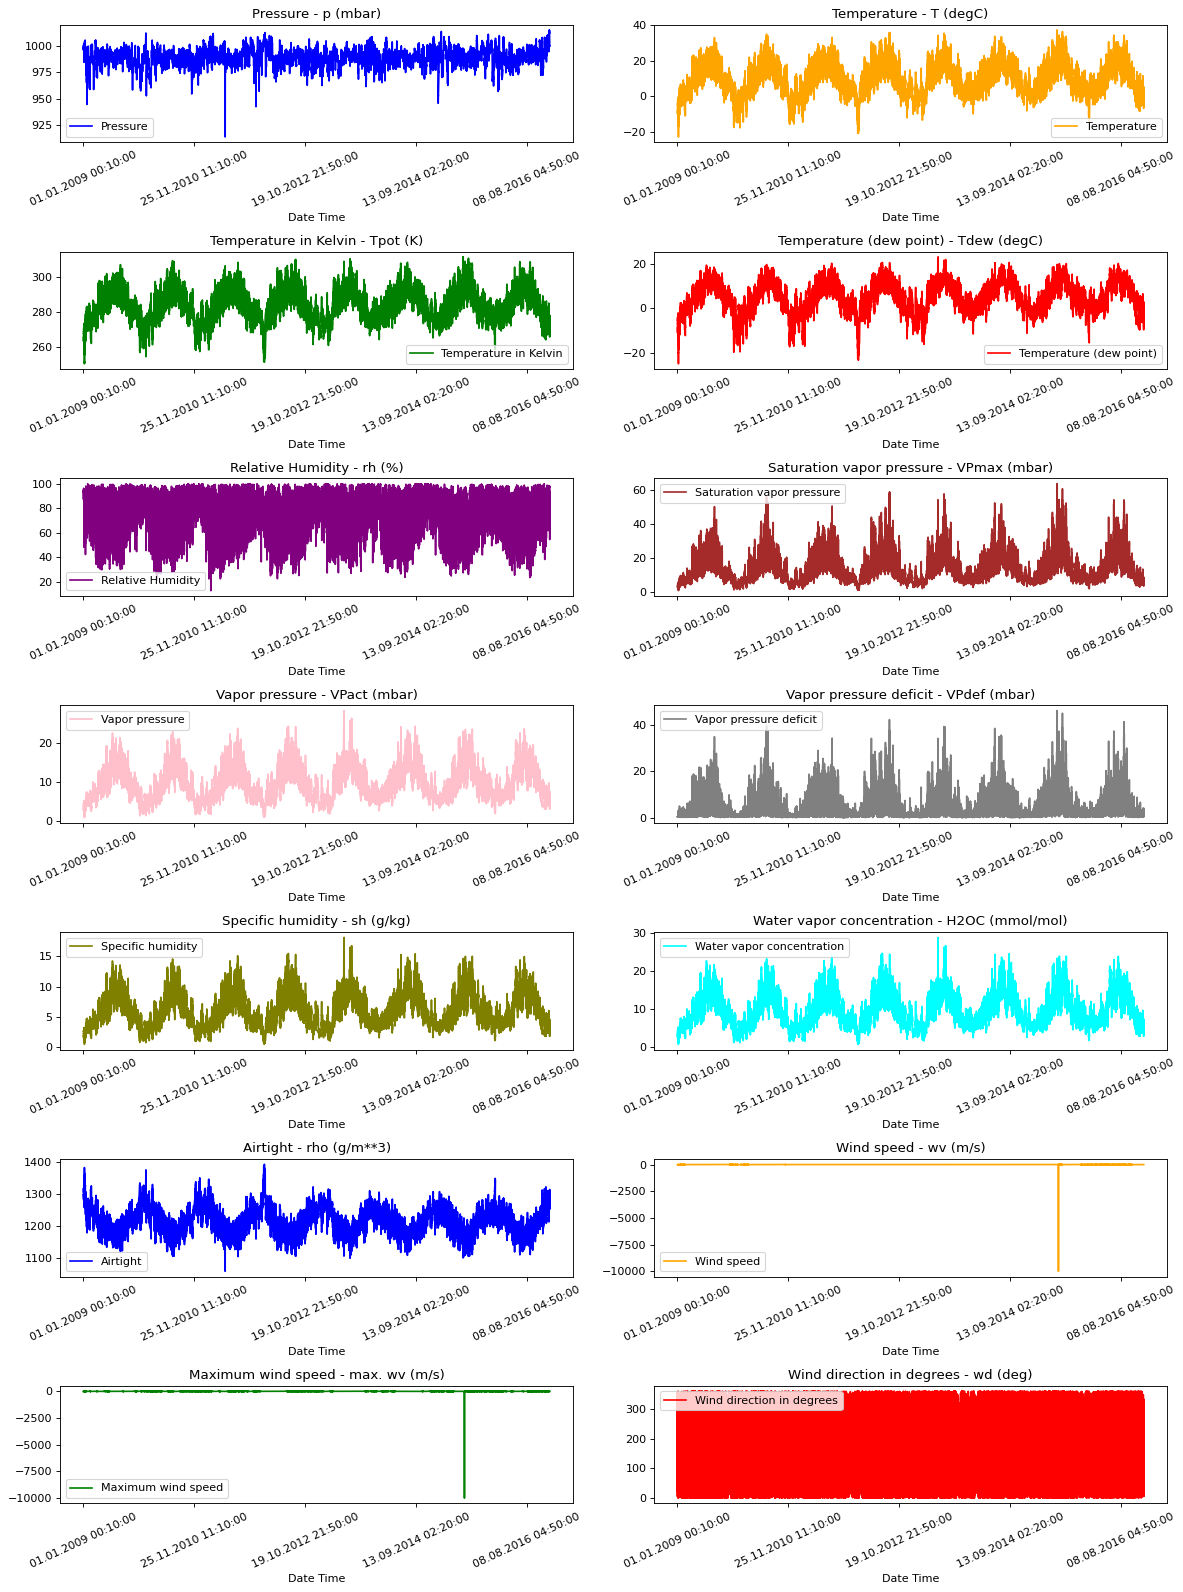

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

# Step 3: Data Preprocessing

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

# Step 4: Feature Engineering using Heat-Map

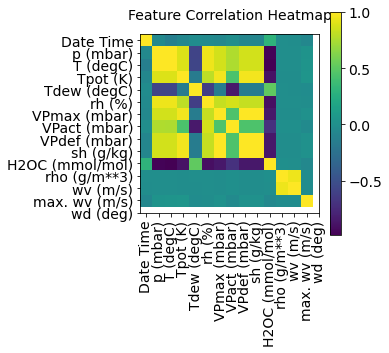

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [ ]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# Step 5: Splitting Training and Validation Data

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


# Step 6: Designing LSTM Architecture

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
#cnn_out = keras.layers.Dense(64)(lstm_out)
outputs = keras.layers.Dense(1)(cnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


# Step 7: Training the model

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - 64s 48ms/step - loss: 0.1872 - val_loss: 0.1601

Epoch 00001: val_loss improved from inf to 0.16013, saving model to model_checkpoint.h5
Epoch 2/10
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1245 - val_loss: 0.1508

Epoch 00002: val_loss improved from 0.16013 to 0.15083, saving model to model_checkpoint.h5
Epoch 3/10
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1154 - val_loss: 0.1559

Epoch 00003: val_loss did not improve from 0.15083
Epoch 4/10
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1114 - val_loss: 0.1570

Epoch 00004: val_loss did not improve from 0.15083
Epoch 5/10
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1093 - val_loss: 0.1536

Epoch 00005: val_loss did not improve from 0.15083
Epoch 6/10
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1076 - val_loss: 0.1512

Epoch 00006: val_loss did not improve

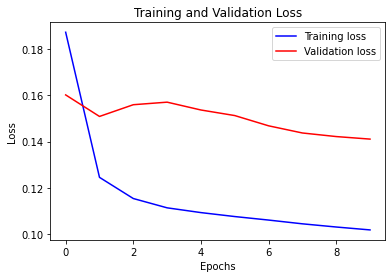

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

# Step 8: Forecasting Future

0.22580110082877844
0.3586359918117523
Error: 58.83  %


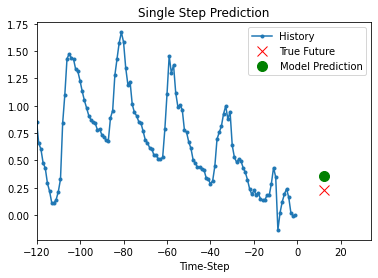

0.43425468961869884
-0.1864812672138214
Error: 142.94  %


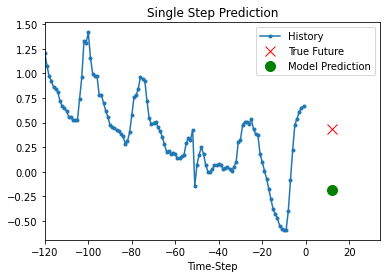

1.1441549669977051
0.7005235552787781
Error: 38.77  %


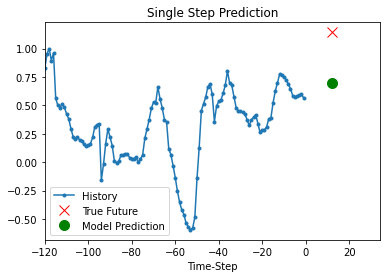

0.7411446953371927
1.1293222904205322
Error: 52.38  %


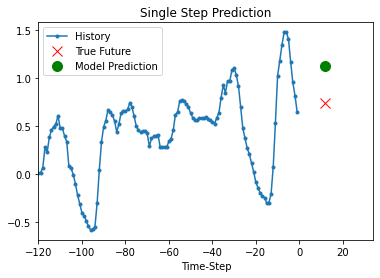

0.6091240891035764
0.3858546316623688
Error: 36.65  %


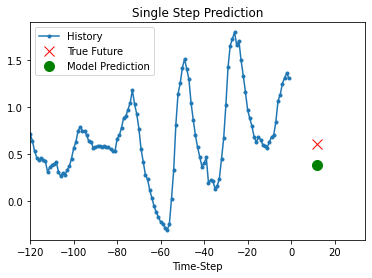

0.4991069172422297
0.4724157154560089
Error: 5.35  %


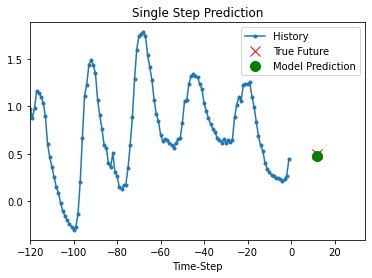

0.711034732511982
0.8360303640365601
Error: 17.58  %


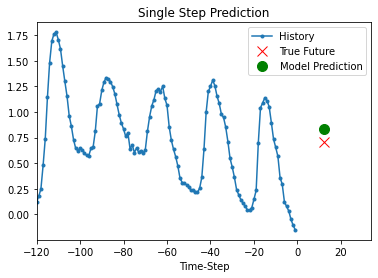

0.65544710883467
0.9489091634750366
Error: 44.77  %


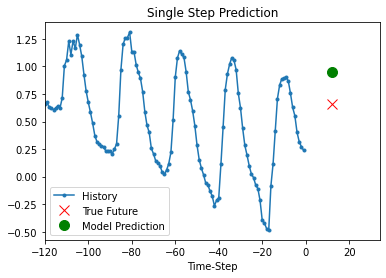

0.30686638535819205
0.3215734660625458
Error: 4.79  %


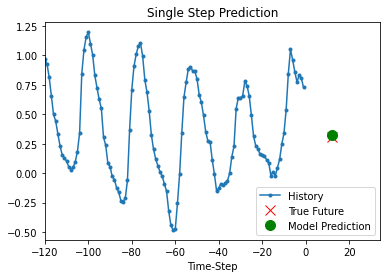

0.8511618671985397
0.7050559520721436
Error: 17.17  %


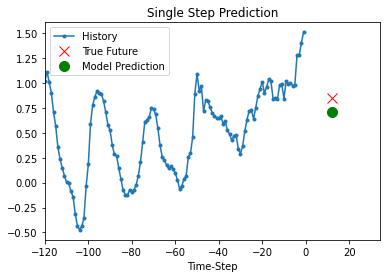

In [ ]:
def show_plot(plot_data, delta, title):
    trueval=float(plot_data[1])
    print(trueval)
    pred=float(plot_data[2])
    print(pred)
    err=round(((abs(pred-trueval)/trueval)*100),2)
    print("Error: "+str(err)+"  %")
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
data_mean = features.values[:train_split].mean(axis=0)
data_std = features.values[:train_split].std(axis=0)

In [ ]:
model=tf.keras.models.load_model("/content/LSTM_Wheather.h5")

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trueval=float(0.43425468961869884)
pred=(-0.1864812672138214)

err=round(((abs(pred-trueval)/trueval)*100),2)

In [ ]:
pred-trueval

-0.6207359568325203

In [ ]:
(pred-trueval)/trueval

-1.4294283324322024

In [ ]:
print(err)

142.94
